In [2]:
DATASET_NAME = 'enhanced-vulnerability-audits'

# Add root to path
import sys
current_path = sys.path[0]
root_name = 'data-lifecycle'
root_path = current_path[:sys.path[0].find(root_name) + len(root_name)]
if root_path not in sys.path:
    sys.path.insert(0, root_path)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModel
import torch
from datasets import DatasetDict
from common.directories import DATASET_DIR
import matplotlib.pyplot as plt
import pandas as pd
from plotter import Plotter

plotter = Plotter(DATASET_NAME)

In [5]:
df_train = DatasetDict.load_from_disk(DATASET_DIR / DATASET_NAME)['train'].to_pandas()
df_test = DatasetDict.load_from_disk(DATASET_DIR / DATASET_NAME)['test'].to_pandas()

# concatenate train and test
df = pd.concat([df_train, df_test])

In [8]:
reentrancy_df = df[df['type'].str.contains('reentrancy', case=False, na=False)]
print(len(reentrancy_df))

arithmetic_df = df[df['type'].str.contains('arithmetic', case=False, na=False)]
print(len(arithmetic_df))


239
270


In [10]:
df_size = min(50, len(reentrancy_df), len(arithmetic_df))
combined_df = pd.concat([reentrancy_df.head(df_size), arithmetic_df.head(df_size)])

In [19]:
def encode_queries(queries, model, tokenizer):
    encoded_queries = []
    for query in queries:
        inputs = tokenizer(query.replace("\\n", "\n"), return_tensors='pt', padding=True, truncation=True, max_length=256)
        with torch.no_grad():
            outputs = model(**inputs)
        # Use the mean of the last hidden state as the sentence embedding
        embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        encoded_queries.append(embeddings)
    return np.array(encoded_queries)

def run_dim_reduction(df, field, model, tokenizer, title, plotname, Algo=PCA, annotate=False):
    queries = df[field]
    encoded_queries = encode_queries(queries, model, tokenizer)

    # Apply dimensionality reduction
    algo_result = Algo(n_components=2).fit_transform(encoded_queries)

    # Separate the results into two clusters
    cluster_1 = algo_result[:df_size]
    cluster_2 = algo_result[df_size:]

    # Prepare data for SVM
    X = np.vstack((cluster_1, cluster_2))
    y = np.array([0] * df_size + [1] * df_size)  # Create labels for the two clusters

    # Fit a linear SVM
    svm = SVC(kernel='linear').fit(X, y)

    # Create a mesh to plot the decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the clusters and decision boundary
    plt.figure(figsize=(10, 7))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['lightcoral', 'lightblue']))
    plt.scatter(cluster_1[:, 0], cluster_1[:, 1], c='coral', label='Reentrancy vulnerability')
    plt.scatter(cluster_2[:, 0], cluster_2[:, 1], c='mediumturquoise', label='Arithmetic error')

    # Annotate points with query texts
    if annotate:
        for i, type in enumerate(df['type']):
            plt.annotate(type, (algo_result[i, 0], algo_result[i, 1]))

    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.grid(which="major", linestyle='-', linewidth='0.5', color='gray')
    plotter.save_plot(plotname)

# PCA

## Description

### Bert Base

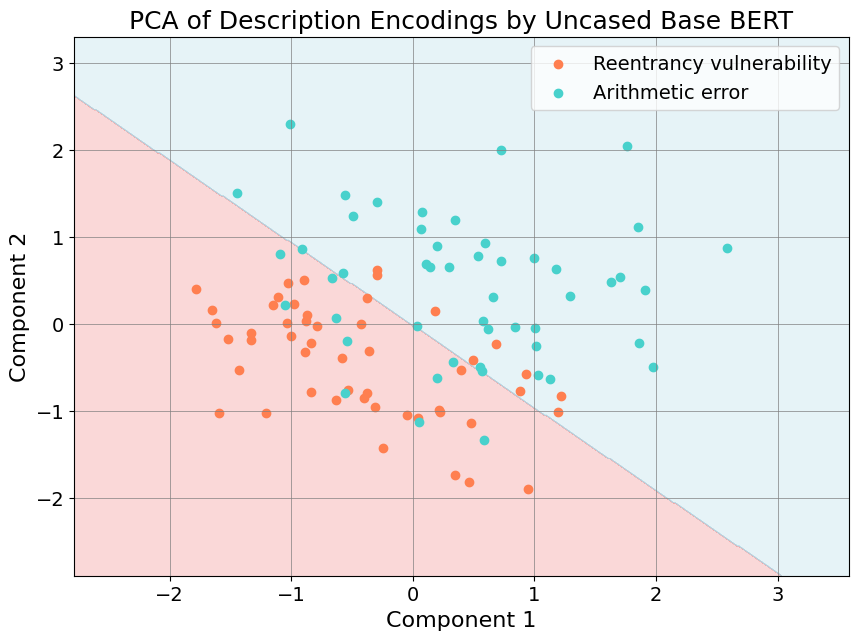

In [72]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

run_dim_reduction(combined_df, 'description', model, tokenizer, 'PCA of Description Encodings by Uncased Base BERT', 'pca-descriptions-bert-base-uncased')

### Bert Large

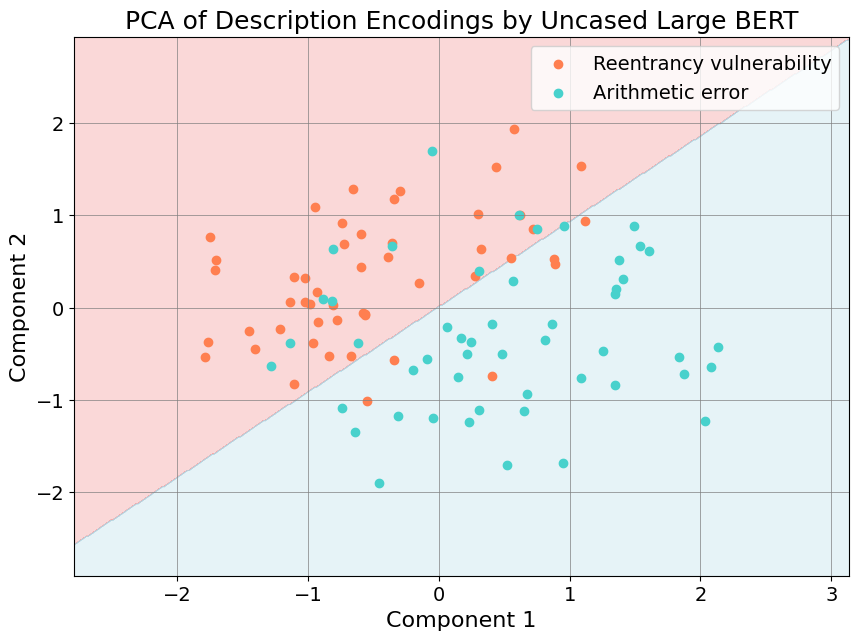

In [73]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
model = BertModel.from_pretrained('bert-large-uncased')

run_dim_reduction(combined_df, 'description', model, tokenizer, 'PCA of Description Encodings by Uncased Large BERT', 'pca-descriptions-bert-large-uncased')


### Bert Base Cased

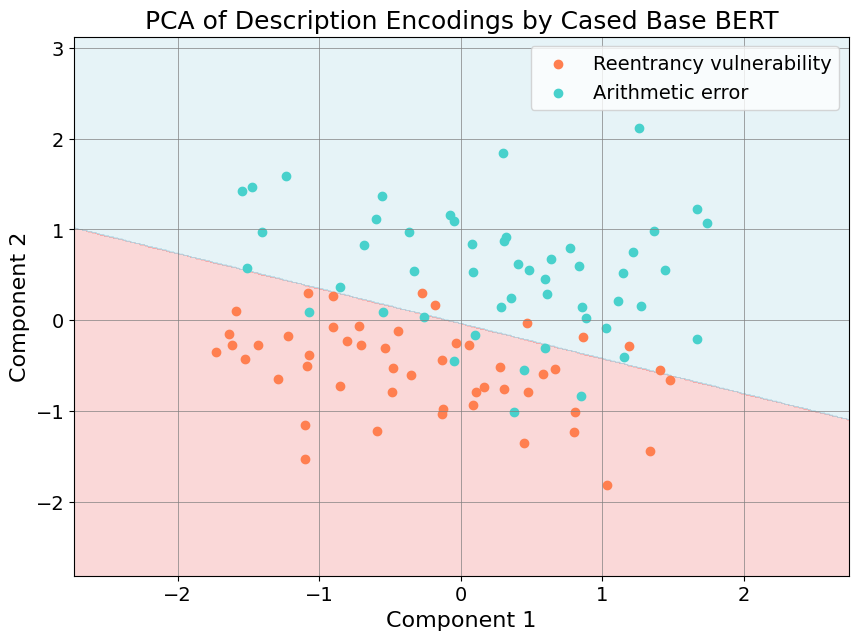

In [74]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained('bert-base-cased')

run_dim_reduction(combined_df, 'description', model, tokenizer, 'PCA of Description Encodings by Cased Base BERT', 'pca-descriptions-bert-base-cased')


### Bert Large Cased

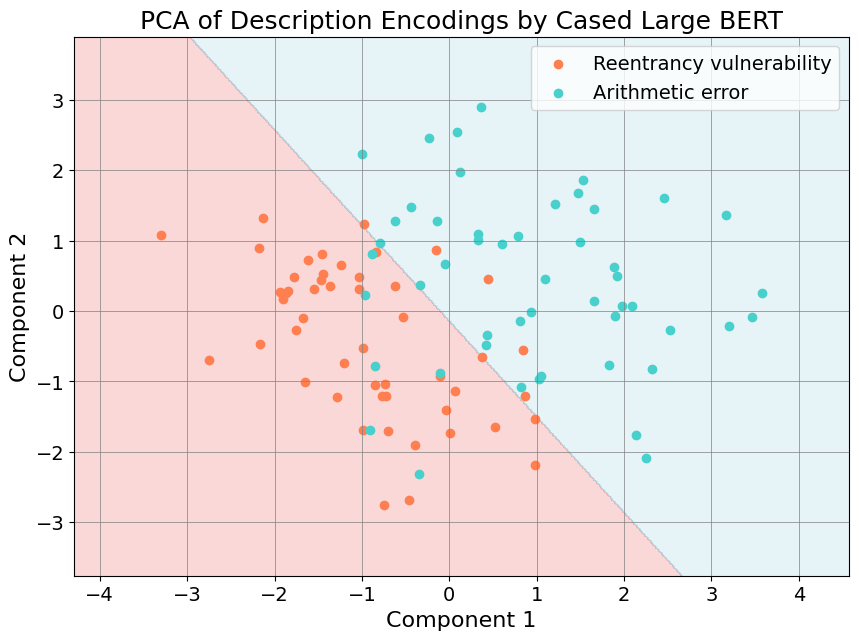

In [75]:
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')
model = BertModel.from_pretrained('bert-large-cased')

run_dim_reduction(combined_df, 'description', model, tokenizer, 'PCA of Description Encodings by Cased Large BERT', 'pca-descriptions-bert-large-cased')


### RoBERTa

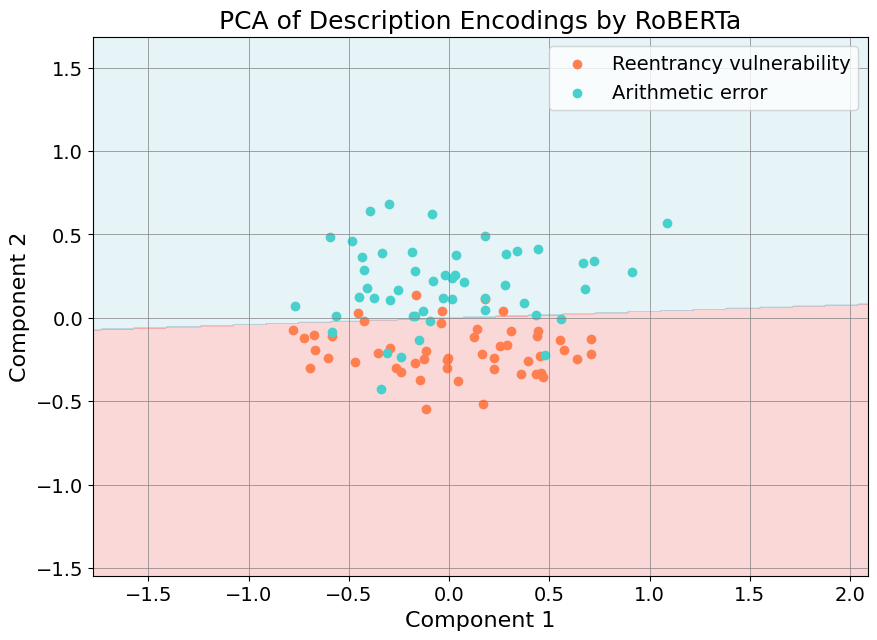

In [76]:
tokenizer = AutoTokenizer.from_pretrained('FacebookAI/xlm-roberta-large')
model = AutoModel.from_pretrained("FacebookAI/xlm-roberta-large")

run_dim_reduction(combined_df, 'description', model, tokenizer, 'PCA of Description Encodings by RoBERTa', 'pca-descriptions-roberta')


## Code

### Base Bert

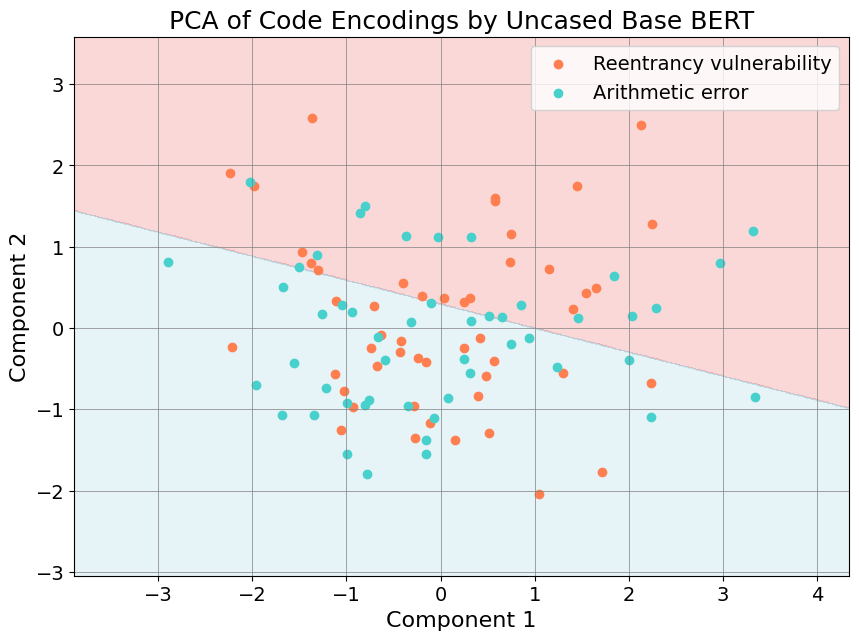

In [77]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

run_dim_reduction(combined_df, 'code', model, tokenizer, 'PCA of Code Encodings by Uncased Base BERT', 'pca-code-bert-base-uncased')

### Bert Large

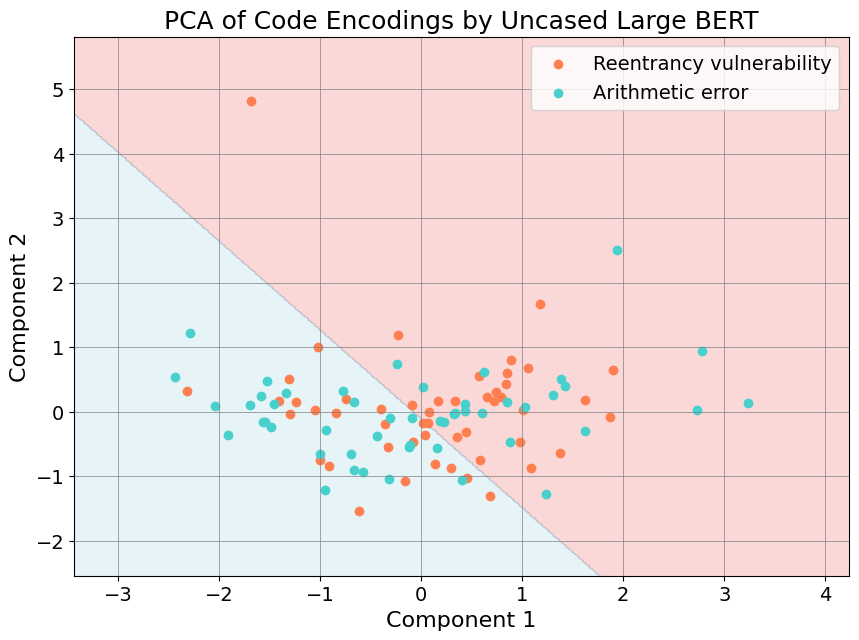

In [78]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
model = BertModel.from_pretrained('bert-large-uncased')

run_dim_reduction(combined_df, 'code', model, tokenizer, 'PCA of Code Encodings by Uncased Large BERT', 'pca-code-bert-large-uncased')

### Bert Base Cased

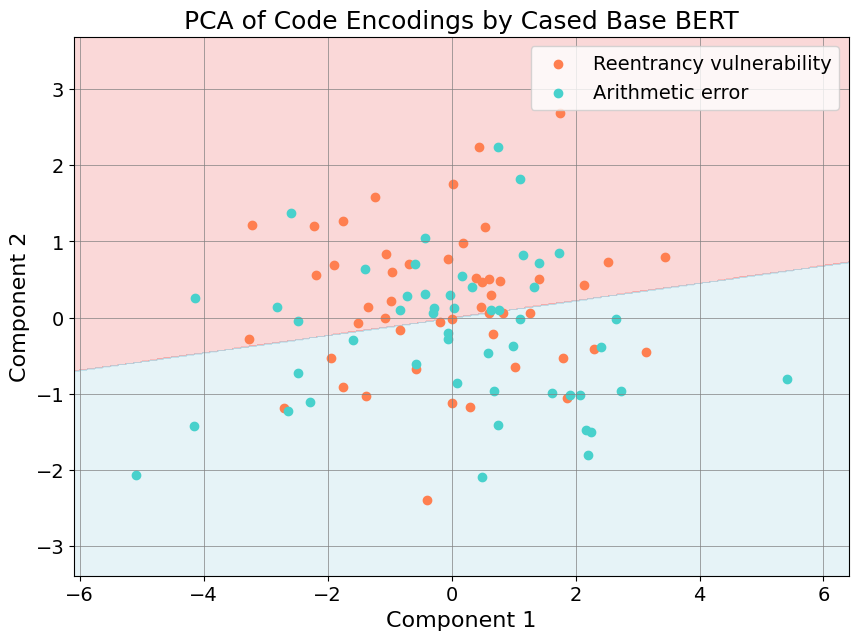

In [79]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained('bert-base-cased')

run_dim_reduction(combined_df, 'code', model, tokenizer, 'PCA of Code Encodings by Cased Base BERT', 'pca-code-bert-base-cased')

### Bert Large Cased

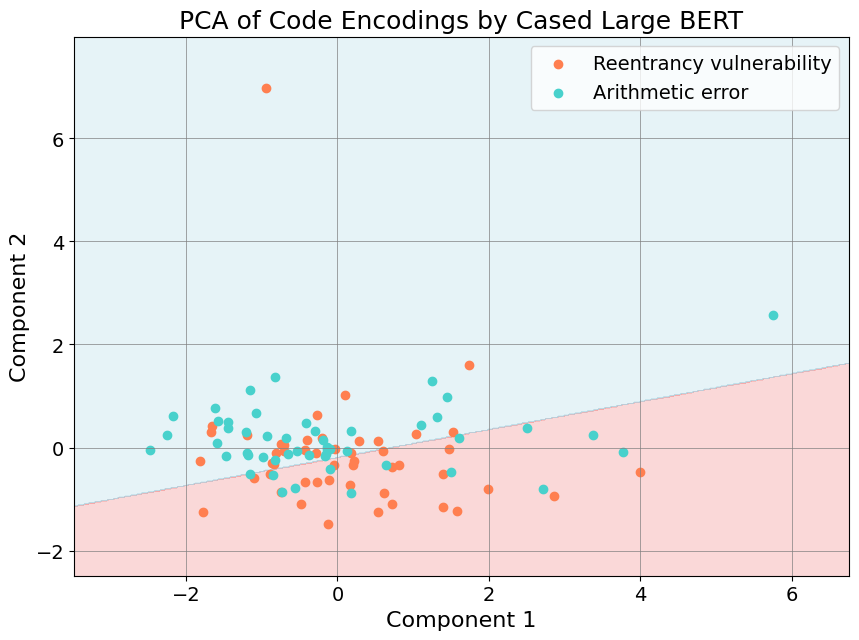

In [80]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')
model = BertModel.from_pretrained('bert-large-cased')

run_dim_reduction(combined_df, 'code', model, tokenizer, 'PCA of Code Encodings by Cased Large BERT', 'pca-code-bert-large-cased')

### RoBERTa

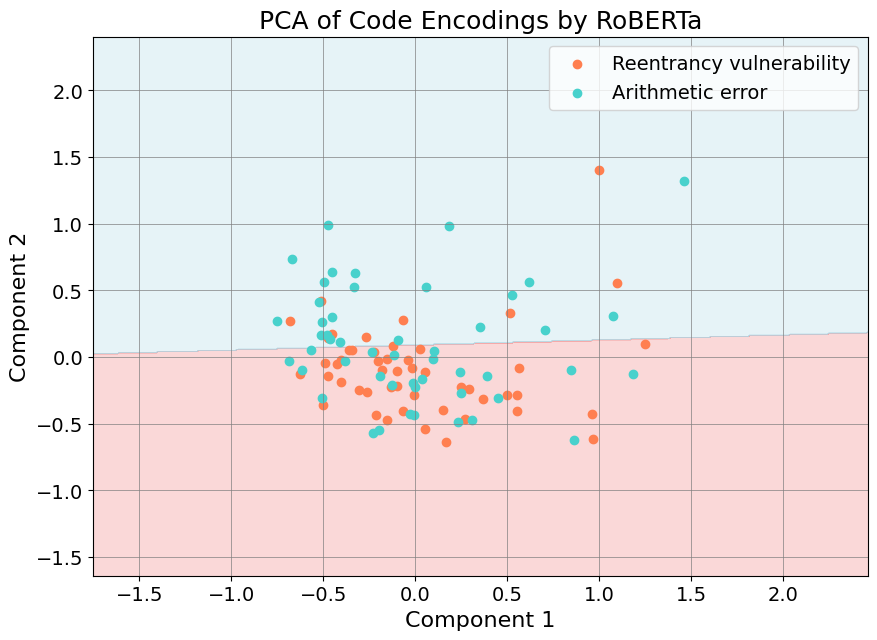

In [81]:
tokenizer = AutoTokenizer.from_pretrained('FacebookAI/xlm-roberta-large')
model = AutoModel.from_pretrained("FacebookAI/xlm-roberta-large")

run_dim_reduction(combined_df, 'code', model, tokenizer, 'PCA of Code Encodings by RoBERTa', 'pca-code-roberta')

## Functionality

### Bert Base

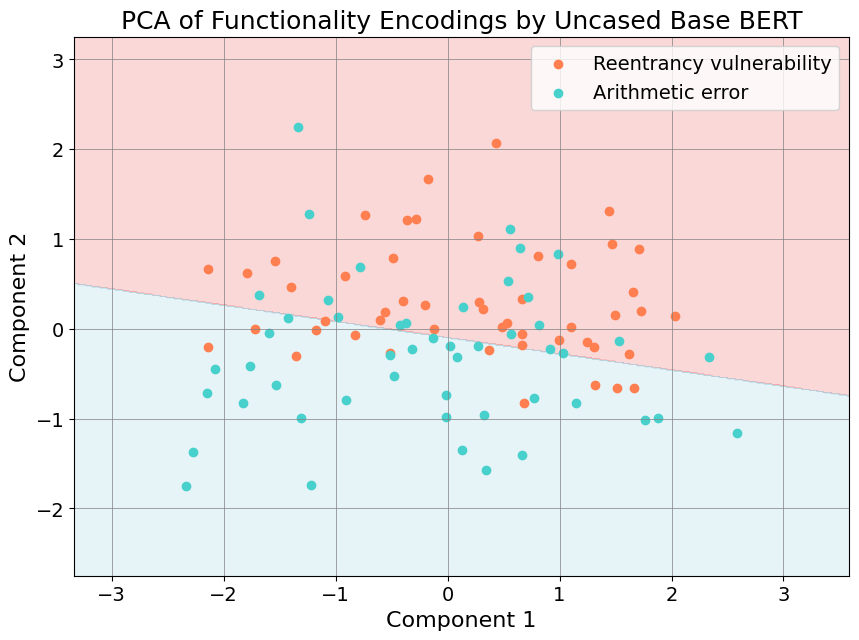

In [82]:
from transformers import BertTokenizer, BertModel

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

run_dim_reduction(combined_df, 'functionality', model, tokenizer, 'PCA of Functionality Encodings by Uncased Base BERT', 'pca-functionalities-bert-base-uncased')

### Bert Large

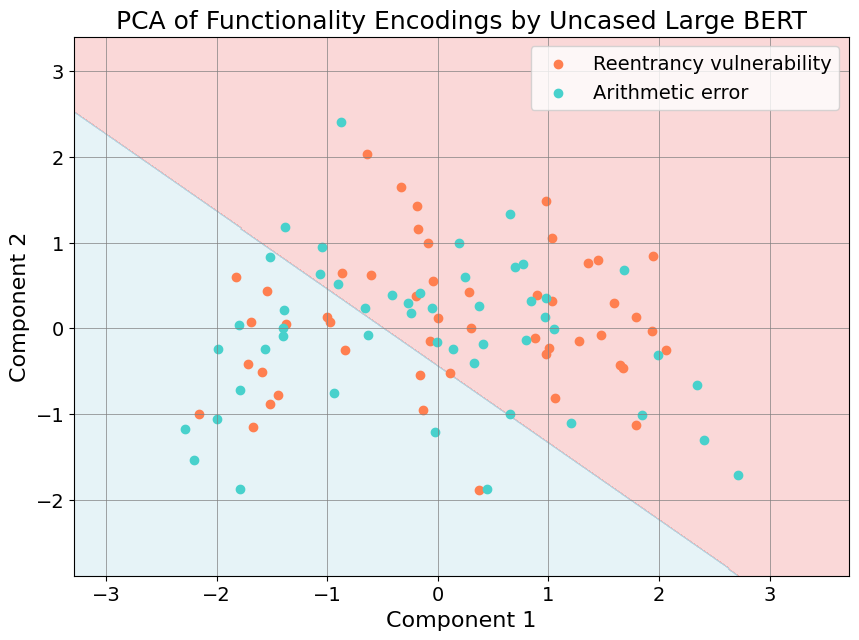

In [83]:
from transformers import BertTokenizer, BertModel

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
model = BertModel.from_pretrained('bert-large-uncased')

run_dim_reduction(combined_df, 'functionality', model, tokenizer, 'PCA of Functionality Encodings by Uncased Large BERT', 'pca-functionalities-bert-large-uncased')

### Bert Base Cased

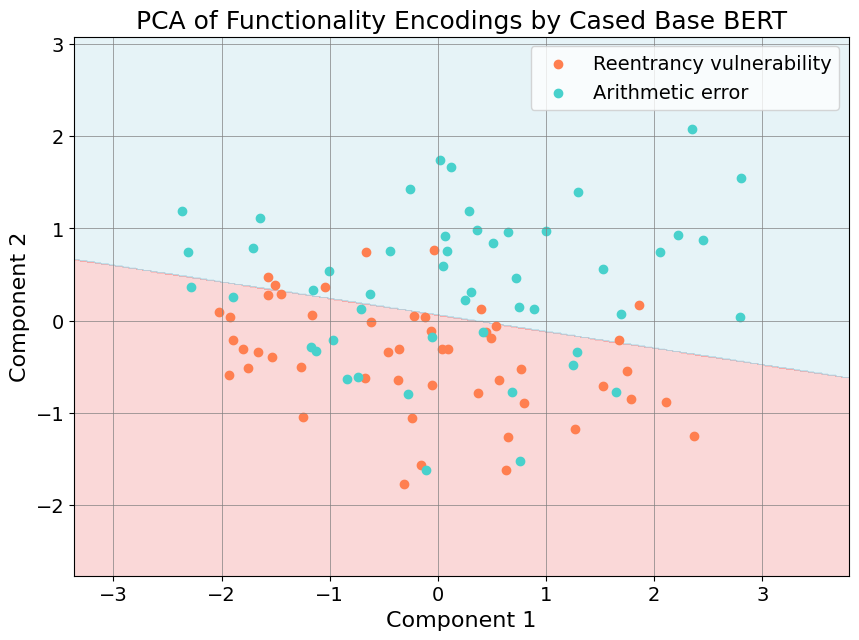

In [84]:
from transformers import BertTokenizer, BertModel

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained('bert-base-cased')

run_dim_reduction(combined_df, 'functionality', model, tokenizer, 'PCA of Functionality Encodings by Cased Base BERT', 'pca-functionalities-bert-base-cased')

### Bert Large Cased

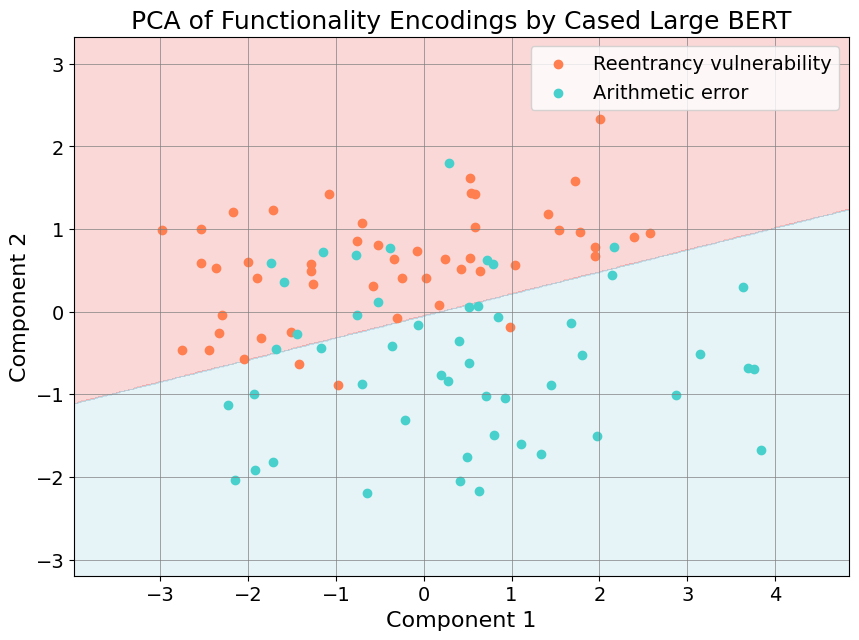

In [85]:
from transformers import BertTokenizer, BertModel

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')
model = BertModel.from_pretrained('bert-large-cased')

run_dim_reduction(combined_df, 'functionality', model, tokenizer, 'PCA of Functionality Encodings by Cased Large BERT', 'pca-functionalities-bert-large-cased')

# TSNE

## Code

### BERT

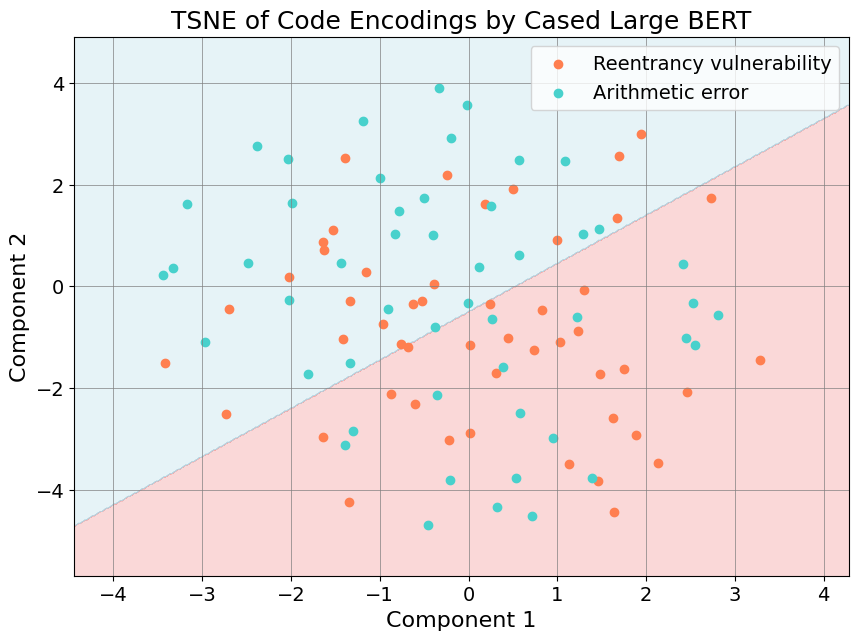

In [86]:
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')
model = BertModel.from_pretrained('bert-large-cased')

run_dim_reduction(combined_df, 'code', model, tokenizer, 'TSNE of Code Encodings by Cased Large BERT', 'tsne-code-bert-large-cased', Algo=TSNE)


### RoBERTa

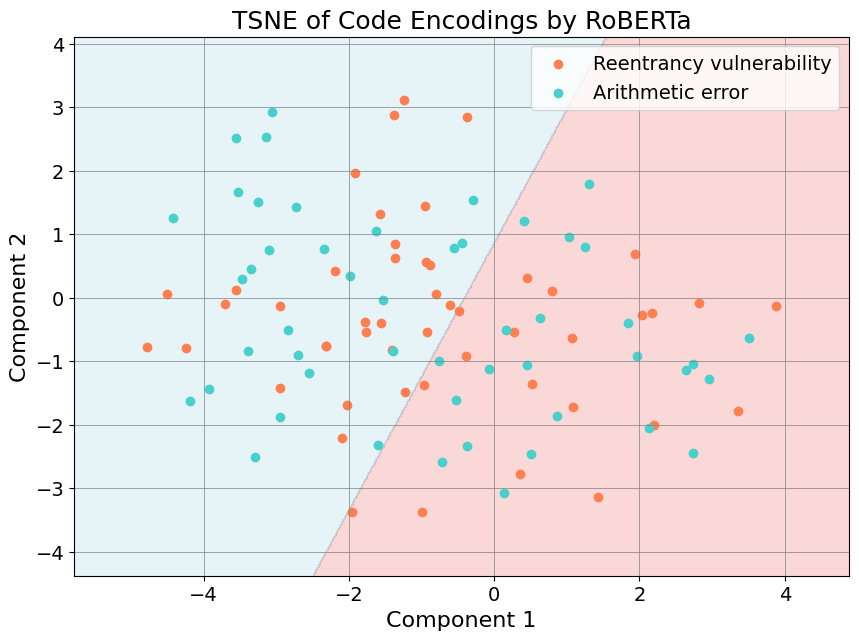

In [87]:
tokenizer = AutoTokenizer.from_pretrained('FacebookAI/xlm-roberta-large')
model = AutoModel.from_pretrained("FacebookAI/xlm-roberta-large")

run_dim_reduction(combined_df, 'code', model, tokenizer, 'TSNE of Code Encodings by RoBERTa', 'tsne-code-roberta', Algo=TSNE)

## Functionality

### BERT

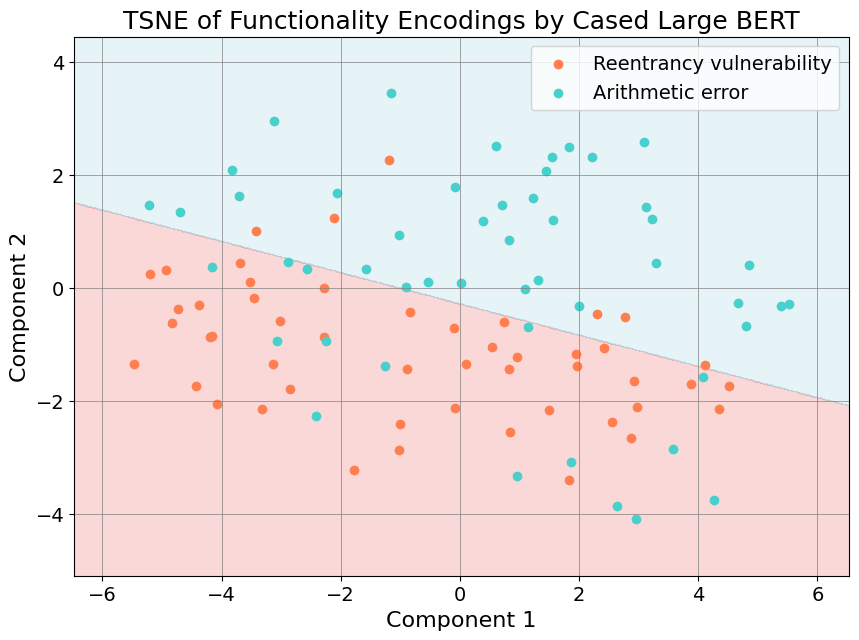

In [88]:
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')
model = BertModel.from_pretrained('bert-large-cased')

run_dim_reduction(
    combined_df,
    'functionality',
    model,
    tokenizer,
    'TSNE of Functionality Encodings by Cased Large BERT',
    'tsne-functionality-bert-large-cased',
    Algo=TSNE
)

### RoBERTa

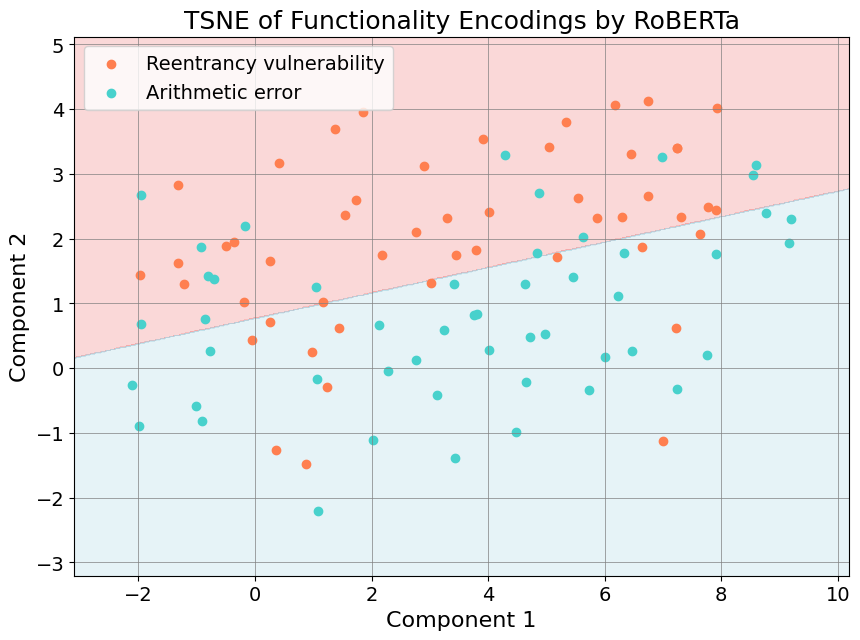

In [89]:
tokenizer = AutoTokenizer.from_pretrained('FacebookAI/xlm-roberta-large')
model = AutoModel.from_pretrained("FacebookAI/xlm-roberta-large")

run_dim_reduction(combined_df, 'functionality', model, tokenizer, 'TSNE of Functionality Encodings by RoBERTa', 'tsne-functionality-roberta', Algo=TSNE)

# Vulnearble vs Verified

In [11]:
verified_df = df[df['type'].str.contains('no vulnerability', case=False, na=False)]
print(len(verified_df))

938


In [12]:
combined_df = pd.concat([reentrancy_df.head(df_size), arithmetic_df.head(df_size), verified_df.head(df_size)])

In [25]:
def compare_embeddings(df, field, model, tokenizer, title, plotname, Algo=PCA, annotate=False):
    queries = df[field]
    encoded_queries = encode_queries(queries, model, tokenizer)

    # Apply dimensionality reduction
    algo_result = Algo(n_components=2).fit_transform(encoded_queries)

    # Separate the results into two clusters
    cluster_1 = algo_result[:df_size]
    cluster_2 = algo_result[df_size:df_size*2]
    cluster_v = algo_result[df_size*2:]

    # Plot the clusters and decision boundary
    plt.figure(figsize=(10, 7))
    plt.scatter(cluster_1[:, 0], cluster_1[:, 1], c='limegreen', label='Reentrancy vulnerability')
    plt.scatter(cluster_2[:, 0], cluster_2[:, 1], c='mediumturquoise', label='Arithmetic error')
    plt.scatter(cluster_v[:, 0], cluster_v[:, 1], c='coral', label='Verified')

    # Annotate points with query texts
    if annotate:
        for i, type in enumerate(df['type']):
            plt.annotate(type, (algo_result[i, 0], algo_result[i, 1]))

    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.grid(which="major", linestyle='-', linewidth='0.5', color='gray')
    plotter.save_plot(plotname)

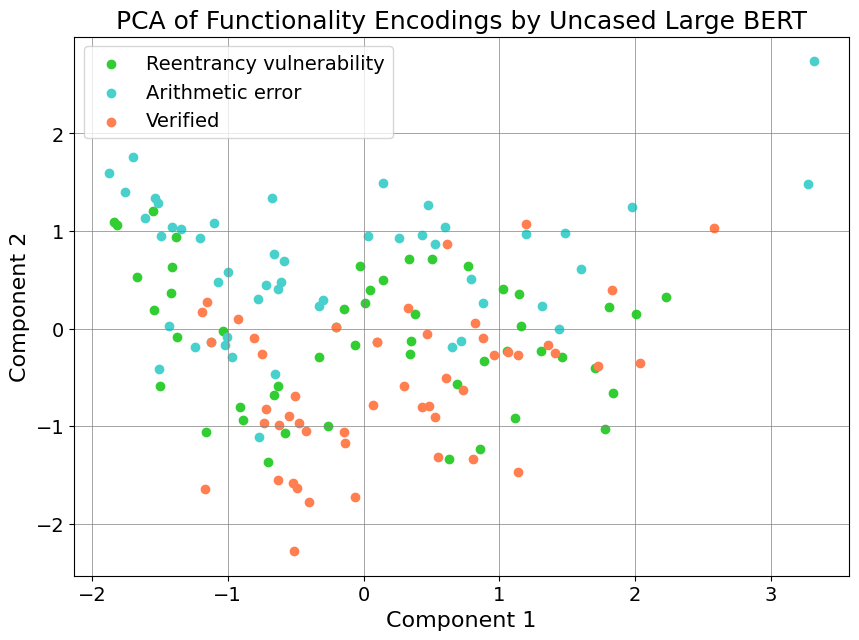

In [26]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
model = BertModel.from_pretrained('bert-large-uncased')

compare_embeddings(combined_df, 'functionality', model, tokenizer, 'PCA of Functionality Encodings by Uncased Large BERT', 'pca-descriptions-bert-large-uncased-all')

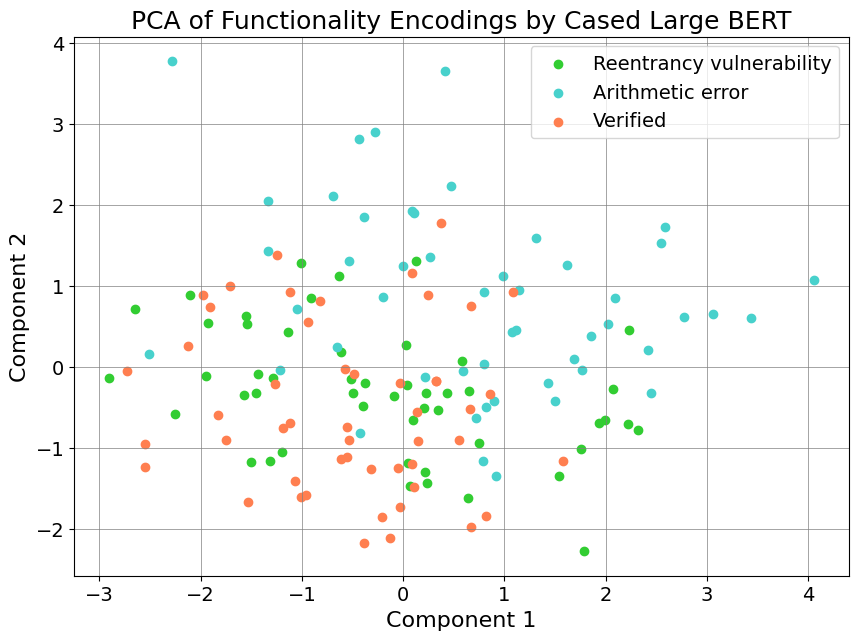

In [27]:
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')
model = BertModel.from_pretrained('bert-large-cased')

compare_embeddings(combined_df, 'functionality', model, tokenizer, 'PCA of Functionality Encodings by Cased Large BERT', 'pca-descriptions-bert-large-cased-all')

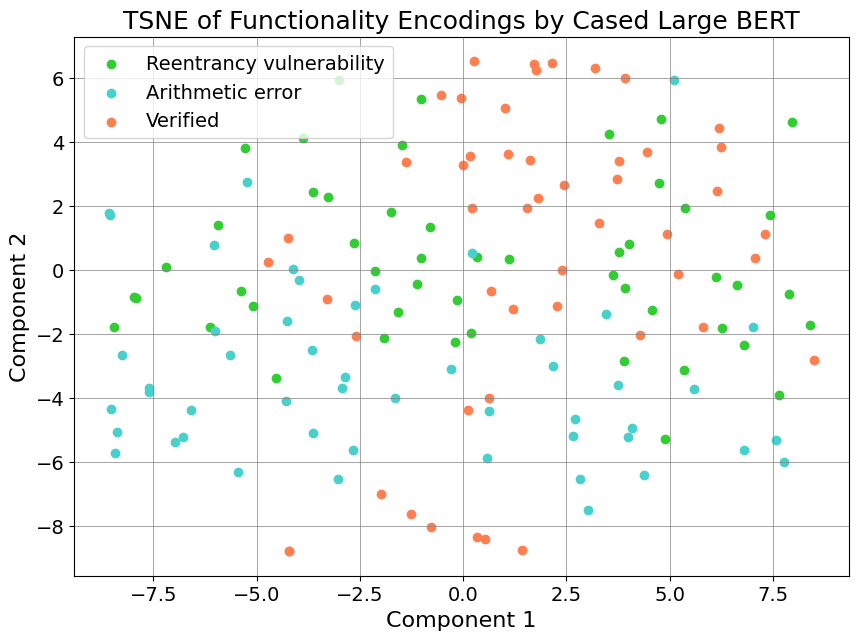

In [28]:
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')
model = BertModel.from_pretrained('bert-large-cased')

compare_embeddings(combined_df, 'functionality', model, tokenizer, 'TSNE of Functionality Encodings by Cased Large BERT', 'tsne-descriptions-bert-large-cased-all', Algo=TSNE)

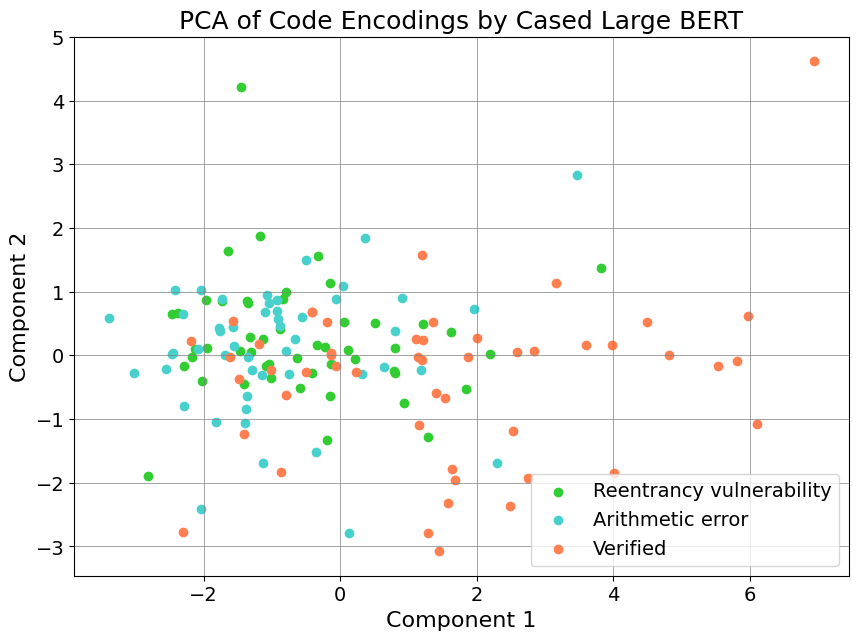

In [29]:
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')
model = BertModel.from_pretrained('bert-large-cased')

compare_embeddings(combined_df, 'code', model, tokenizer, 'PCA of Code Encodings by Cased Large BERT', 'pca-code-bert-large-cased-all')

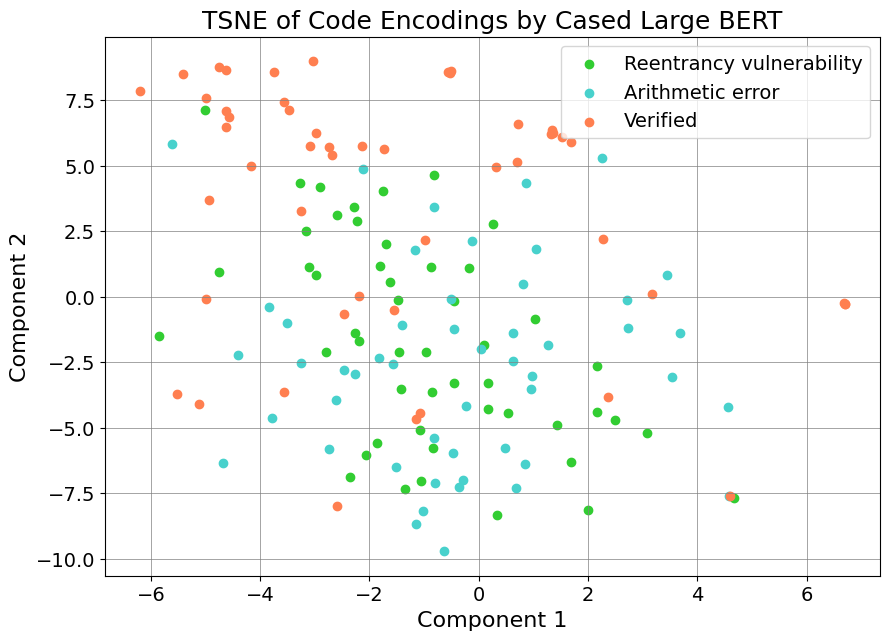

In [30]:
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')
model = BertModel.from_pretrained('bert-large-cased')

compare_embeddings(combined_df, 'code', model, tokenizer, 'TSNE of Code Encodings by Cased Large BERT', 'tsne-code-bert-large-cased-all', Algo=TSNE)